In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, Input, MaxPooling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from time import time
import csv
import random

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from helper import load_and_preprocess_image, generator_from_csv

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [2]:
# CSV paths
TRAIN_CSV = 'annotations_train.csv'
VAL_CSV   = 'annotations_val.csv'
TEST_CSV  = 'annotations_test.csv'

In [3]:
# Hyperparameters
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS   = 3
BATCH_SIZE = 8
EPOCHS     = 15

In [4]:
# Data generators for train, val, test sets
train_gen = generator_from_csv(TRAIN_CSV, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = generator_from_csv(VAL_CSV,   batch_size=BATCH_SIZE, shuffle=False)
test_gen  = generator_from_csv(TEST_CSV,  batch_size=BATCH_SIZE, shuffle=False)

# Let's guess how many lines are in each CSV
train_lines = sum(1 for _ in open(TRAIN_CSV)) - 1  # minus header
val_lines   = sum(1 for _ in open(VAL_CSV))   - 1
test_lines  = sum(1 for _ in open(TEST_CSV))  - 1

# Steps per epoch
steps_per_epoch      = train_lines // BATCH_SIZE
validation_steps     = val_lines   // BATCH_SIZE
test_steps           = test_lines  // BATCH_SIZE

In [5]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10,
                           restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('unet_best_model.h5', monitor='val_loss',
                             save_best_only=True, verbose=1)

In [6]:
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    return model


In [7]:
model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
plot_model(model, show_shapes=True)

In [8]:
# Fit the model
history = model.fit(
    x=train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/15
131/131 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.7148 - mae: 0.0673
Epoch 1: val_loss improved from inf to 0.00190, saving model to unet_best_model.h5
131/131 [==============================] - 63s 409ms/step - loss: 0.0112 - accuracy: 0.7148 - mae: 0.0673 - val_loss: 0.0019 - val_accuracy: 0.8874 - val_mae: 0.0322 - lr: 0.0010
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.8959 - mae: 0.0293
Epoch 2: val_loss improved from 0.00190 to 0.00112, saving model to unet_best_model.h5
131/131 [==============================] - 44s 338ms/step - loss: 0.0016 - accuracy: 0.8959 - mae: 0.0293 - val_loss: 0.0011 - val_accuracy: 0.8741 - val_mae: 0.0235 - lr: 0.0010
Epoch 3/15
131/131 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.8994 - mae: 0.0264
Epoch 3: val_loss did not improve from 0.00112
131/131 [==============================] - 43s 330ms/step - loss: 0.0013 - accuracy: 0.8994 - m

Train Acc      0.9150286912918091
Validation Acc 0.9138593077659607


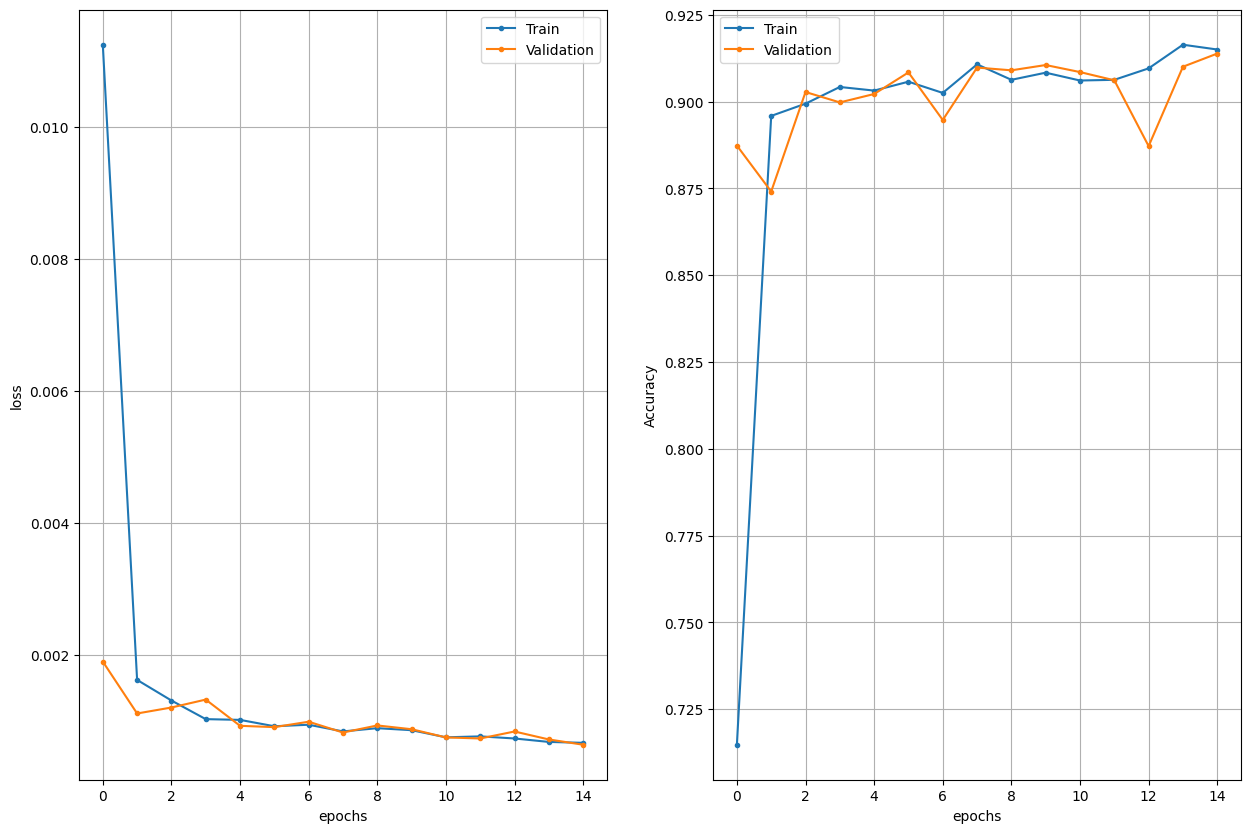

In [9]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

1/1 [==============================] - 0s 31ms/step


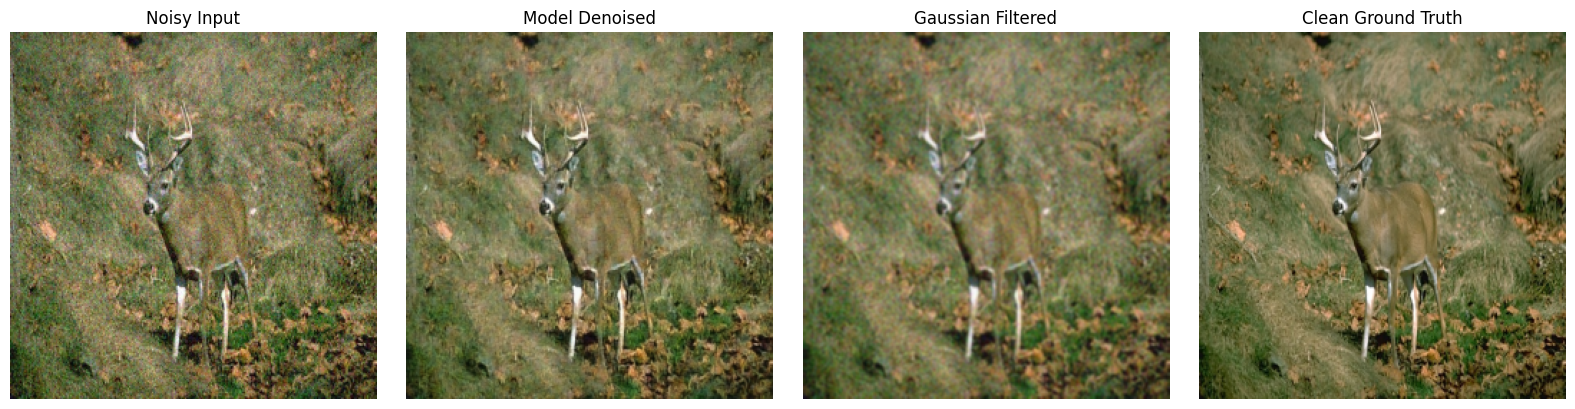

In [18]:
# Get one batch from the generator
noisy_batch, originaln_batch = next(train_gen)

# Use model to predict
predicts = model.predict(noisy_batch)

idx = 0

# Convert to uint8 because OpenCV GaussianBlur expects 8 bit.
noisy_uint8 = (noisy_batch[idx] * 255).astype(np.uint8)

# Apply Gaussianblur (5,5) is the kernel size, and 0 is the sigma (auto-calculated based on kernel size).
gaussian_img = cv2.GaussianBlur(noisy_uint8, (3, 3), 0)

# Convert back to float for plotting
gaussian_img = gaussian_img.astype(np.float32) / 255.0

plt.figure(figsize=(16, 4))

# Noisy Input
plt.subplot(1, 4, 1)
plt.title("Noisy Input")
plt.imshow(noisy_batch[idx])
plt.axis('off')

# Model Denoised
plt.subplot(1, 4, 2)
plt.title("Model Denoised")
plt.imshow(predicts[idx])
plt.axis('off')

# Gaussian Filtered
plt.subplot(1, 4, 3)
plt.title("Gaussian Filtered")
plt.imshow(gaussian_img) 
plt.axis('off')

# Clean Ground Truth
plt.subplot(1, 4, 4)
plt.title("Clean Ground Truth")
plt.imshow(originaln_batch[idx])
plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
def mse(img1, img2):
    return np.mean((img1 - img2)**2)

def psnr(img1, img2):
    # Assumes images in [0..1], so max_val = 1.0
    mse_val = mse(img1, img2)
    if mse_val == 0:
        return 100  # max PSNR if identical
    return 10 * np.log10(1.0 / mse_val)

# Compare model output vs ground truth
model_psnr = psnr(preds[idx], clean_batch[idx])
print("Model PSNR:", model_psnr)

# Compare Gaussian vs ground truth
gaussian_psnr = psnr(gaussian_img, clean_batch[idx])
print("Gaussian PSNR:", gaussian_psnr)


Model PSNR: 37.638427825122314
Gaussian PSNR: 12.210095440257371
